In [2]:

# Set up GPU rendering.
import distutils.util
import os
import subprocess
# if subprocess.run('nvidia-smi').returncode:
#   raise RuntimeError(
#       'Cannot communicate with GPU. '
#       'Make sure you are using a GPU Colab runtime. '
#       'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#   with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#     f.write("""{
#     "file_format_version" : "1.0.0",
#     "ICD" : {
#         "library_path" : "libEGL_nvidia.so.0"
#     }
# }
# """)

# # Configure MuJoCo to use the EGL rendering backend (requires GPU)
# print('Setting environment variable to use GPU rendering:')
# %env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()



In [7]:
xml_string_mujoco = '''
<mujoco>
  <worldbody>
    <!-- Node A -->
    <body name="A" pos="0 0 0">
      <geom name="geom_A" size="0.02" type="sphere" rgba="0.8 0.2 0.1 1"/>
      <site name="site_A" pos="0 0 0" size="0.01"/>
      <joint name="joint_A" type="free"/>
    </body>

    <!-- Node B -->
    <body name="B" pos="0.1 0 0">
      <geom name="geom_B" size="0.02" type="sphere" rgba="0.2 0.8 0.1 1"/>
      <site name="site_B" pos="0 0 0" size="0.01"/>
      <joint name="joint_B" type="free"/>
    </body>

    <!-- Node C -->
    <body name="C" pos="0 0.1 0">
      <geom name="geom_C" size="0.02" type="sphere" rgba="0.1 0.2 0.8 1"/>
      <site name="site_C" pos="0 0 0" size="0.01"/>
      <joint name="joint_C" type="free"/>
    </body>

    <!-- Node D -->
    <body name="D" pos="0.1 0.1 0">
      <geom name="geom_D" size="0.02" type="sphere" rgba="0.8 0.8 0.1 1"/>
      <site name="site_D" pos="0 0 0" size="0.01"/>
      <joint name="joint_D" type="free"/>
    </body>
  </worldbody>

  <!-- Tendon Definitions -->
  <tendon>
    <!-- Edge A-B -->
    <spatial name="tendon_AB" width="0.01">
      <site site="site_A"/>
      <site site="site_B"/>
    </spatial>

    <!-- Edge A-C -->
    <spatial name="tendon_AC" width="0.01">
      <site site="site_A"/>
      <site site="site_C"/>
    </spatial>

    <!-- Edge C-D -->
    <spatial name="tendon_CD" width="0.01">
      <site site="site_C"/>
      <site site="site_D"/>
    </spatial>
  </tendon>
</mujoco>
'''


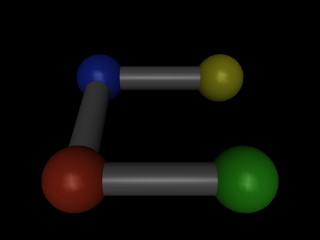

In [8]:
model = mujoco.MjModel.from_xml_string(xml_string_mujoco)
data = mujoco.MjData(model)
with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)

  media.show_image(renderer.render())

In [12]:
def generate_graph_mujoco_xml(adjacency, position_dict=None):
    """
    Generate MuJoCo XML for a graph.
    
    Args:
        adjacency (dict or list): 
            - If dict: adjacency list where keys are nodes and values are lists of connected nodes.
            - If list: adjacency matrix (square list of lists or numpy array).
        position_dict (dict): Dictionary with node positions as {node: (x, y, z)}. Defaults to None.
            - If None, positions will be generated in a simple grid layout.
    
    Returns:
        str: MuJoCo XML string representing the graph.
    """
    # Handle adjacency list or matrix
    if isinstance(adjacency, list):
        from collections import defaultdict
        adjacency_list = defaultdict(list)
        for i, row in enumerate(adjacency):
            for j, value in enumerate(row):
                if value:  # Non-zero indicates an edge
                    adjacency_list[i].append(j)
    else:
        adjacency_list = adjacency

    # Handle positions
    if position_dict is None:
        position_dict = {
            node: (i, 0, 0) for i, node in enumerate(adjacency_list)
        }
    
    # Ensure all nodes in adjacency list are in position_dict
    for node in adjacency_list:
        if node not in position_dict:
            raise ValueError(f"Node {node} in adjacency list but not in position_dict")

    xml = '<mujoco>\n  <asset>\n'
    # add texture and material for the grid
    xml += '    <texture name="grid" type="2d" builtin="checker" rgb1="0.8 0.8 0.8" rgb2="0.4 0.4 0.4" width="512" height="512"/>\n'
    xml += '    <material name="grid" texture="grid" texrepeat="8 8" texuniform="true"/>\n'
    xml += '  </asset>\n'

    # Start worldbody
    xml += '  <worldbody>\n'
    
    # Add a light source
    xml += '    <light name="top" pos="0 0 10" dir="0 0 -1" diffuse="1 1 1"/>\n'

    # Add a visual grid on the floor
    xml += '    <geom type="plane" size="10 10 0.1" rgba="1 1 1 1" material="grid"/>\n'
    
    # Add nodes (bodies and geoms)
    for node, position in position_dict.items():
        xml += f'    <!-- Node {node} -->\n'
        xml += f'    <body name="{node}" pos="{position[0]} {position[1]} {position[2]}">\n'
        xml += f'      <geom name="geom_{node}" size="0.02" type="sphere" rgba="0.8 0.2 0.1 1"/>\n'
        xml += f'      <site name="site_{node}" pos="0 0 0" size="0.01"/>\n'
        xml += f'      <joint name="joint_{node}" type="free"/>\n'
        xml += '    </body>\n'

    # Close worldbody
    xml += '  </worldbody>\n'

    # Tendons section for edges
    xml += '    <!-- Tendon Definitions -->\n'
    xml += '  <tendon>\n'
    for node, neighbors in adjacency_list.items():
        for neighbor in neighbors:
            if node < neighbor:  # Avoid duplicating edges
                xml += f'    <!-- Edge {node}-{neighbor} -->\n'
                xml += f'    <spatial name="tendon_{node}_{neighbor}" width="0.01">\n'
                xml += f'      <site site="site_{node}"/>\n'
                xml += f'      <site site="site_{neighbor}"/>\n'
                xml += '    </spatial>\n'
    xml += '  </tendon>\n'

    xml += '  </mujoco>'
    return xml


In [ ]:
import networkx as nx 
G = nx.erdos_renyi_graph(10, 0.4)

adjacency = G.adj
pos = nx.spring_layout(G, dim=3)
# ensure that all z values are positive, subtract the min z value from all z values
min_z = min([pos[node][2] for node in pos])
for node in pos:
    pos[node] = (pos[node][0], pos[node][1], pos[node][2] - min_z + .5)
xml = generate_graph_mujoco_xml(adjacency, pos)
print(xml)
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

duration = 5 # seconds
framerate = 60 # frames per second

frames = []
#mujoco.mj_forward(model, data)
mujoco.mj_resetData(model, data)
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data)
      pixels = renderer.render()
      frames.append(pixels)

  media.show_video(frames, fps = framerate)

In [99]:
model.opt

<MjOption
  apirate: 100.0
  ccd_iterations: 50
  ccd_tolerance: 1e-06
  cone: 0
  density: 0.0
  disableactuator: 0
  disableflags: 0
  enableflags: 0
  gravity: array([ 0.  ,  0.  , -9.81])
  impratio: 1.0
  integrator: 0
  iterations: 100
  jacobian: 2
  ls_iterations: 50
  ls_tolerance: 0.01
  magnetic: array([ 0. , -0.5,  0. ])
  noslip_iterations: 0
  noslip_tolerance: 1e-06
  o_friction: array([1.   , 1.   , 0.005, 0.   , 0.   ])
  o_margin: 0.0
  o_solimp: array([0.9  , 0.95 , 0.001, 0.5  , 2.   ])
  o_solref: array([0.02, 1.  ])
  sdf_initpoints: 40
  sdf_iterations: 10
  solver: 2
  timestep: 0.002
  tolerance: 1e-08
  viscosity: 0.0
  wind: array([0., 0., 0.])
>


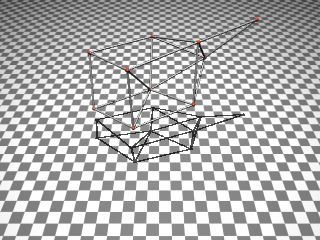

In [15]:
import mujoco
import numpy as np

G = nx.erdos_renyi_graph(10, 0.4)

adjacency = G.adj
pos = nx.spring_layout(G, dim=3)
# ensure that all z values are positive, subtract the min z value from all z values
min_z = min([pos[node][2] for node in pos])
for node in pos:
    pos[node] = (pos[node][0], pos[node][1], pos[node][2] - min_z + .5)
xml = generate_graph_mujoco_xml(adjacency, pos)
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# Simulation parameters
duration = 5  # seconds
framerate = 60  # Hz
dt = 1.0 / framerate  # Time step size

# Initial conditions
num_nodes = 10
positions = np.zeros((num_nodes, 3))  # Store positions (x, y, z)
for i, pos in enumerate(pos.values()):
    positions[i] = pos

#display the model
with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)

  media.show_image(renderer.render())


In [16]:
positions

array([[ 0.363, -0.276,  0.71 ],
       [ 1.   ,  0.269,  1.392],
       [-0.101,  0.002,  0.692],
       [ 0.387,  0.003,  1.288],
       [-0.304, -0.249,  1.131],
       [-0.758,  0.188,  1.056],
       [-0.079,  0.401,  1.128],
       [-0.751, -0.11 ,  0.5  ],
       [ 0.513,  0.241,  0.959],
       [-0.27 , -0.468,  0.553]])

In [17]:
def random_noise_derivative(positions):
    """Generate random noise for the derivative of the positions."""
    return np.random.normal(loc=0, scale=5, size=positions.shape)

In [18]:
def half_left_half_right(positions, speed = .5):
    # makes the left half of the nodes move up and the right half move down
    derivative = np.zeros_like(positions)
    derivative[:len(derivative)//2, 2] = speed
    derivative[len(derivative)//2:, 2] = -speed
    return derivative


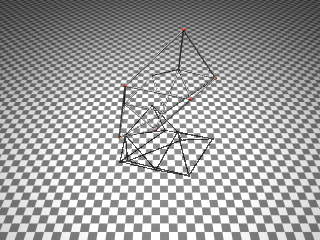

In [333]:
import mujoco
import numpy as np

G = nx.erdos_renyi_graph(10, 0.4)

adjacency = G.adj
pos = nx.spring_layout(G, dim=3)
# ensure that all z values are positive, subtract the min z value from all z values
min_z = min([pos[node][2] for node in pos])
for node in pos:
    pos[node] = (pos[node][0], pos[node][1], pos[node][2] - min_z + .5)
xml = generate_graph_mujoco_xml(adjacency, pos)
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# Simulation parameters
duration = 5  # seconds
framerate = 60  # Hz
dt = 1.0 / framerate  # Time step size

# Initial conditions
num_nodes = 10
positions = np.zeros((num_nodes, 3))  # Store positions (x, y, z)
for i, pos in enumerate(pos.values()):
    positions[i] = pos

#display the model
with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)

  media.show_image(renderer.render())

# Initialize data.qpos with initial positions
for i, pos in enumerate(positions):
    data.qpos[3 * i:3 * i + 3] = pos
mujoco.mj_forward(model, data)  # Synchronize MuJoCo's state with initial positions

# Simulate and render frames
frames = []
time_elapsed = 0
derivatives = half_left_half_right(positions)

with mujoco.Renderer(model) as renderer:
    while time_elapsed < duration:
        # Update positions using your dynamics
        positions += derivatives * dt

        # Directly update positions in MuJoCo
        for i, pos in enumerate(positions):
            data.qpos[7 * i:7 * i + 3] = pos  # Update node positions
        mujoco.mj_forward(model, data)  # Synchronize MuJoCo state

        # Render and capture frames
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)

        # Debug print
        #print(f"Time: {time_elapsed:.2f}s, Positions:\n{positions}")

        time_elapsed += dt

# Display the video
media.show_video(frames, fps=framerate)



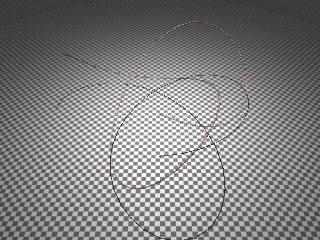

In [292]:
# make a path graph and make a video of the nodes moving up and down
num_nodes = 50
G = nx.path_graph(num_nodes)
adjacency = G.adj

pos = nx.spring_layout(G, dim=3)
# make position a linearly spaced path
for i, node in enumerate(pos):
    pos[node] = (i/num_nodes * 4 - 2, 0, 0)

# use trefoil knot to make a path
pos = get_trefoil_pos(num_nodes, 7 * np.pi/4)

# ensure that all z values are positive, subtract the min z value from all z values
min_z = min([pos[node][2] for node in pos])
for node in pos:
    pos[node] = (pos[node][0], pos[node][1], pos[node][2] - min_z + .5)
xml = generate_graph_mujoco_xml(adjacency, pos)
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# save the xml
with open('path_graph_trefoil.xml', 'w') as f:
    f.write(xml) 

# Simulation parameters
duration = 5  # seconds
framerate = 60  # Hz
dt = 1.0 / framerate  # Time step size

# Initial conditions
positions = np.zeros((num_nodes, 3))  # Store positions (x, y, z)
for i, pos in enumerate(pos.values()):
    positions[i] = pos

#display the model
with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  # turn off shadows
  renderer._shadow = False
  renderer.update_scene(data)

  media.show_image(renderer.render())


In [293]:
def visualize_pos(model, pos):
    data = mujoco.MjData(model)
    # Initial conditions
    num_nodes = len(pos)
    positions = np.zeros((num_nodes, 3))  # Store positions (x, y, z)
    for i, pos in enumerate(pos.values()):
        positions[i] = pos
    print(data.qpos.shape)
    
    for i, pos in enumerate(positions):
        data.qpos[7 * i:7 * i + 3] = pos  # Update node positions
    # # Simulation parameters
    # duration = 5  # seconds
    # framerate = 60  # Hz
    # dt = 1.0 / framerate  # Time step size

    #display the model
    with mujoco.Renderer(model) as renderer:
        mujoco.mj_forward(model, data)
        # turn off shadows
        renderer._shadow = False
        renderer.update_scene(data)

        media.show_image(renderer.render())

    return None

In [183]:
pos

{5: (-4.595089614833771, -2.1886223574482693, 5.955036443425321),
 6: (-4.803957324598943, -2.242650646423191, 6.065276601468865),
 7: (-4.908391179481528, -2.2696647909106513, 6.120396680490637),
 8: (-4.960608106922821, -2.2831718631543816, 6.147956720001522),
 9: (-4.986716570643468, -2.289925399276247, 6.1617367397569645),
 10: (-4.999770802503791, -2.2933021673371794, 6.168626749634686),
 11: (-5.006297918433953, -2.2949905513676456, 6.172071754573546),
 12: (-5.009561476399034, -2.295834743382879, 6.173794257042976),
 13: (-5.011193255381574, -2.2962568393904954, 6.1746555082776915),
 14: (-5.012009144872844, -2.2964678873943036, 6.175086133895049),
 15: (-5.012417089618479, -2.2965734113962077, 6.1753014467037275),
 16: (-5.012621061991297, -2.2966261733971596, 6.175409103108066),
 17: (-5.012723048177706, -2.2966525543976353, 6.175462931310236),
 18: (-5.0127740412709105, -2.296665744897873, 6.17548984541132),
 19: (-5.0127995378175125, -2.296672340147992, 6.175503302461863),
 

In [249]:
pos = {i: (i, 0, 0) for i in range(10)}
pos[9] = (8.5, 0, 0)
pos

{0: (0, 0, 0),
 1: (1, 0, 0),
 2: (2, 0, 0),
 3: (3, 0, 0),
 4: (4, 0, 0),
 5: (5, 0, 0),
 6: (6, 0, 0),
 7: (7, 0, 0),
 8: (8, 0, 0),
 9: (8.5, 0, 0)}

In [255]:
print(push_pos_towards_tail(pos, 1))
print(push_pos_towards_tail(pos, 2))

{0: (1, 0, 0), 1: (2, 0, 0), 2: (3, 0, 0), 3: (4, 0, 0), 4: (5, 0, 0), 5: (6, 0, 0), 6: (7, 0, 0), 7: (8, 0, 0), 8: (8.5, 0, 0), 9: (9.0, 0.0, 0.0)}
{0: (1, 0, 0), 1: (2, 0, 0), 2: (3, 0, 0), 3: (4, 0, 0), 4: (5, 0, 0), 5: (6, 0, 0), 6: (7, 0, 0), 7: (8, 0, 0), 8: (8.5, 0, 0), 9: (9.25, 0.0, 0.0)}


In [216]:
def push_pos_towards_tail(pos, num_for_grad = 2):
    # push the first num_for_grad nodes towards the tail of the graph
    # the tail is the last node (node with the highest number)
    pos = pos.copy()
    nodes = list(pos.keys())
    num_nodes = len(nodes)
    for node_num in range(num_nodes - 1):
        pos[node_num] = pos[node_num + 1]
    
    # to update the last node, find the average gradient of the closest num_for_grad nodes
    grad = np.zeros(3)
    for node_num in range(num_nodes - num_for_grad-1, num_nodes-1):
        delta = np.array(pos[node_num]) - np.array(pos[node_num - 1])
        grad += delta
    grad /= num_for_grad
    new_final_pos = np.array(pos[num_nodes - 1]) + grad
    # make new_final_pos a tuple of type float, not np.float
    new_final_pos = tuple([float(x) for x in new_final_pos])
    pos[nodes[num_nodes - 1]] = new_final_pos
    return pos
    

In [134]:
knotting_positions_coarse = []


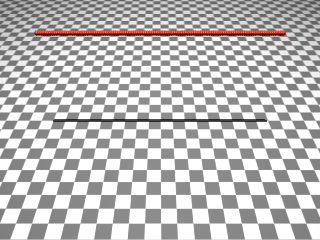

In [135]:
#### GENERATE KNOTTING DYNAMICS #######
num_nodes = 112
G = nx.path_graph(num_nodes)
adjacency = G.adj
pos = nx.spring_layout(G, dim=3)

# make position a linearly spaced path
for i, node in enumerate(pos):
    pos[node] = (i/num_nodes * 2 - 1, 0, 1)


xml = generate_graph_mujoco_xml(adjacency, pos)
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

visualize_pos(model, pos)
knotting_positions_coarse.append(pos)

# # make the next target position:
# # loop through the last half of the nodes
# for i in range(num_nodes//2, num_nodes):
#     pos[i] = 
    

In [155]:
adjacency

AdjacencyView({0: {1: {}}, 1: {0: {}, 2: {}}, 2: {1: {}, 3: {}}, 3: {2: {}, 4: {}}, 4: {3: {}, 5: {}}, 5: {4: {}, 6: {}}, 6: {5: {}, 7: {}}, 7: {6: {}, 8: {}}, 8: {7: {}, 9: {}}, 9: {8: {}, 10: {}}, 10: {9: {}, 11: {}}, 11: {10: {}, 12: {}}, 12: {11: {}, 13: {}}, 13: {12: {}, 14: {}}, 14: {13: {}, 15: {}}, 15: {14: {}, 16: {}}, 16: {15: {}, 17: {}}, 17: {16: {}, 18: {}}, 18: {17: {}, 19: {}}, 19: {18: {}, 20: {}}, 20: {19: {}, 21: {}}, 21: {20: {}, 22: {}}, 22: {21: {}, 23: {}}, 23: {22: {}, 24: {}}, 24: {23: {}, 25: {}}, 25: {24: {}, 26: {}}, 26: {25: {}, 27: {}}, 27: {26: {}, 28: {}}, 28: {27: {}, 29: {}}, 29: {28: {}, 30: {}}, 30: {29: {}, 31: {}}, 31: {30: {}, 32: {}}, 32: {31: {}, 33: {}}, 33: {32: {}, 34: {}}, 34: {33: {}, 35: {}}, 35: {34: {}, 36: {}}, 36: {35: {}, 37: {}}, 37: {36: {}, 38: {}}, 38: {37: {}, 39: {}}, 39: {38: {}, 40: {}}, 40: {39: {}, 41: {}}, 41: {40: {}, 42: {}}, 42: {41: {}, 43: {}}, 43: {42: {}, 44: {}}, 44: {43: {}, 45: {}}, 45: {44: {}, 46: {}}, 46: {45: {

In [ ]:
import networkx as nx 

def overhand_knot_dynamics(positions, speed = .5):
    # makes the left half of the nodes move up and the right half move down
    derivative = np.zeros_like(positions)
    derivative[:len(derivative)//2, 2] = speed
    derivative[len(derivative)//2:, 2] = -speed
    return derivative

AdjacencyView({0: {1: {}, 3: {}, 4: {}, 8: {}, 9: {}}, 1: {0: {}, 2: {}, 4: {}, 5: {}, 7: {}, 8: {}, 9: {}}, 2: {1: {}, 4: {}, 5: {}, 7: {}, 8: {}, 9: {}}, 3: {0: {}, 4: {}, 8: {}, 9: {}}, 4: {0: {}, 1: {}, 2: {}, 3: {}, 6: {}, 7: {}, 9: {}}, 5: {1: {}, 2: {}, 6: {}, 7: {}}, 6: {4: {}, 5: {}, 8: {}}, 7: {1: {}, 2: {}, 4: {}, 5: {}}, 8: {0: {}, 1: {}, 2: {}, 3: {}, 6: {}, 9: {}}, 9: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 8: {}}})

In [56]:
G.adj[0]

AtlasView({1: {}, 4: {}, 6: {}})

In [57]:
nx.to_numpy_array(G)

array([[0., 1., 0., 0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

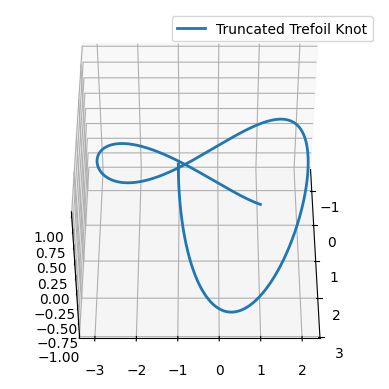

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Trefoil Knot Parametrization
t = np.linspace(0, 5.5 * np.pi / 4, 1000)  # Adjust range for truncation
x = np.sin(t) + 2 * np.sin(2 * t)
y = np.cos(t) - 2 * np.cos(2 * t)
z = -np.sin(3 * t)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# view it from the top
ax.view_init(elev=45, azim=0)
ax.plot(x, y, z, lw=2, label="Truncated Trefoil Knot")
ax.legend()
plt.show()


In [378]:
def get_trefoil_pos(num_nodes, upper_limit = 5.5 * np.pi / 4, scale = 1):
    t = np.linspace(0, upper_limit, num_nodes)  # Adjust range for truncation
    x = (np.sin(t) + 2 * np.sin(2 * t)) * scale
    y = (np.cos(t) - 2 * np.cos(2 * t)) * scale
    z = (-np.sin(3 * t)) * scale
    pos = {}
    for i in range(num_nodes):
        pos[i] = (x[i], y[i], z[i])
    return pos

In [ ]:
def get_overhand_knot(num_nodes, num_nodes_linear_extension = 10, scale = 1):
    # make the trefoil knot
    pos = get_trefoil_pos(num_nodes, scale = scale)
    # extend the ends of the trefoil knot each by num_nodes_linear_extension

    # extend the first num_nodes_linear_extension nodes

    num_nodes_grad_est = 2
    # estimate gradient of the last num_nodes_linear_extension nodes
    tail_grad = np.zeros(3)

    for i in range(num_nodes - num_nodes_grad_est, num_nodes):
        tail_grad += np.array(pos[i]) - np.array(pos[i - 1])
    tail_grad /= num_nodes_grad_est

    for i in range(num_nodes_linear_extension):
        pos[num_nodes + i] = np.array(pos[num_nodes - 1]) + tail_grad * (i + 1)

    # extend the first num_nodes_linear_extension nodes
    head_grad = np.zeros(3)
    for i in range(num_nodes_grad_est):
        head_grad += np.array(pos[i]) - np.array(pos[i + 1])
    head_grad /= num_nodes_grad_est

    for i in range(num_nodes_linear_extension):
        pos[-(i + 1)] = np.array(pos[0]) + head_grad * (i + 1)
    
    # shift all the node labelings to start at 0
    pos = {k+num_nodes_linear_extension:v for k,v in pos.items()} 
    # make sure its a tuple of floats not np.float
    pos = {k:tuple([float(x) for x in v]) for k,v in pos.items()}

    # make pos non-negative in the z direction
    min_z = min([pos[node][2] for node in pos])
    for node in pos:
        pos[node] = (pos[node][0], pos[node][1], pos[node][2] - min_z + .5)

    # sort pos by node number
    pos = dict(sorted(pos.items()))
    
    # make the adjacency dict 
    adjacency = {}
    for i in range(num_nodes - 1):
        adjacency[i] = [i+1]

    G = nx.path_graph(len(pos))
    adjacency = G.adj
    return pos, adjacency

In [265]:
get_overhand_knot(10, 6)

({0: (-8.095611857582426, -7.77285016900715, 4.633475151794077),
  1: (-6.746343214652022, -6.644041807505959, 4.504065629242817),
  2: (-5.3970745717216175, -5.515233446004767, 4.374656106691556),
  3: (-4.047805928791213, -4.386425084503575, 4.245246584140295),
  4: (-2.6985372858608088, -3.2576167230023834, 4.115837061589035),
  5: (-1.3492686429304044, -2.128808361501192, 3.986427539037774),
  6: (0.0, -1.0, 3.8570180164865135),
  7: (2.1000527018130173, -0.2601420395238706, 2.865573155112703),
  8: (2.6985372858608088, 1.2576167230023831, 3.5981989713839924),
  9: (1.5090829515788524, 2.062377844798188, 4.7808975489978),
  10: (-0.3458825985871694, 1.1900687429122883, 4.3570180164865135),
  11: (-1.3167991885678307, -0.9115888223054398, 3.0636646761952786),
  12: (-0.7411809548974799, -2.697976633857945, 3.149911235299965),
  13: (0.628796909543295, -2.788911581193234, 4.465779445495234),
  14: (1.326827896337877, -1.113340798452841, 4.723043420270953),
  15: (0.4903340298618104, 

In [164]:
type(pos)

dict

In [287]:
len(pos) * 7

245

(245,)



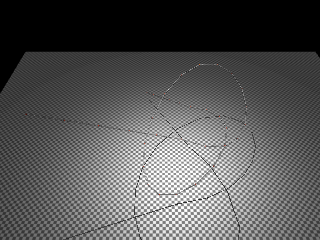

In [334]:
pos, adjacency = get_overhand_knot(25, 5)
xml = generate_graph_mujoco_xml(adjacency, pos)
# save the xml
with open('overhand_knot.xml', 'w') as f:
    f.write(xml)
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

visualize_pos(model, pos)

In [229]:
len(pos)

35

In [296]:
knot_positions = []
knot_positions.append(pos)
for _ in range(len(pos)):
    # push the first num_for_grad nodes towards the tail of the graph
    pos = push_pos_towards_tail(pos, 4)
    knot_positions.append(pos)



0
(245,)



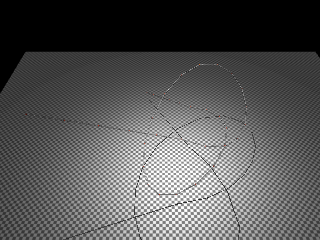

10
(245,)



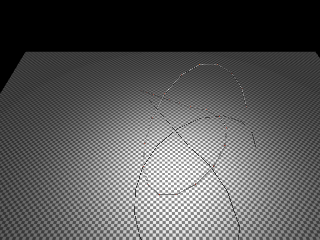

20
(245,)



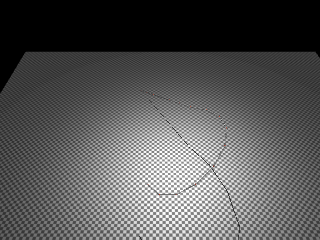

30
(245,)



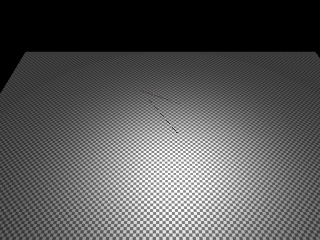

In [313]:
# visualize every 10th position
for i in range(0, len(knot_positions), 10):
    print(i)
    visualize_pos(model, knot_positions[i])

In [402]:
class GraphDynamics:
    def __init__(self, model, data, pos, adjacency):
        self.model = model
        self.data = data
        self.pos = pos
        self.adjacency = adjacency
        self.time_elapsed = 0
    
    # TODO: see if its better to make a class to wrap the model and data and data trajectory

class TrajectoryResampler:
    def __init__(self, reference_frames, framerate, total_time):
        self.reference_frames = reference_frames
        self.framerate = framerate
        self.total_time = total_time
        self.num_frames = len(reference_frames)
        self.target_num_frames = int(total_time * framerate)
        self.points_between_frames = self.target_num_frames // self.num_frames

    def resample_trajectory(self, reverse = False):
        """Interpolate frames to match a target framerate and total time. 
        Linearly interpolates positions to upscale the number of frames.
        """
        num_frames = len(self.reference_frames)
        target_num_frames = int(self.total_time * framerate)
        points_between_frames = target_num_frames / num_frames
        num_nodes = len(self.reference_frames[0])

        # interpolate the positions
        new_positions = []
        for i in range(num_frames - 1):
            start_pos = self.reference_frames[i]
            end_pos = self.reference_frames[i + 1]
            for j in range(self.points_between_frames):
                # pos and end_pos are dictionaries of node number to position
                new_pos = np.zeros((num_nodes,3))
                for node in start_pos:
                    start = np.array(start_pos[node])
                    end = np.array(end_pos[node])
                    pos_at_node = start + (end - start) * j / self.points_between_frames
                    new_pos[node] = pos_at_node
                    #new_pos[node] = tuple([float(x) for x in pos_at_node])
                    
                new_positions.append(new_pos)
                #new_pos = start_pos + (end_pos - start_pos) * j / self.points_between_frames
                #new_positions.append(new_pos)
        if reverse:
            new_positions = new_positions[::-1]
        return np.array(new_positions)

In [403]:
dynamics = TrajectoryResampler(knot_positions, framerate, duration)
new_positions = dynamics.resample_trajectory(reverse=True)

In [ ]:
# visualize every 10th position of new_positions
for i in range(0, len(new_positions), 10):
    print(i)
    visualize_pos(model, new_positions[i])

In [320]:
frame_ind

280


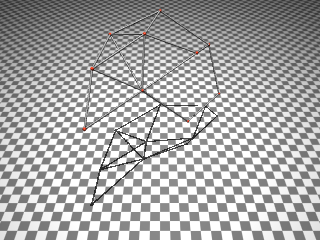

[-0.72  -0.495  1.693]
[-0.72  -0.495  1.701]
[-0.72  -0.495  1.709]
[-0.72  -0.495  1.718]
[-0.72  -0.495  1.726]
[-0.72  -0.495  1.734]
[-0.72  -0.495  1.743]
[-0.72  -0.495  1.751]
[-0.72  -0.495  1.759]
[-0.72  -0.495  1.768]
[-0.72  -0.495  1.776]
[-0.72  -0.495  1.784]
[-0.72  -0.495  1.793]
[-0.72  -0.495  1.801]
[-0.72  -0.495  1.809]
[-0.72  -0.495  1.818]
[-0.72  -0.495  1.826]
[-0.72  -0.495  1.834]
[-0.72  -0.495  1.843]
[-0.72  -0.495  1.851]
[-0.72  -0.495  1.859]
[-0.72  -0.495  1.868]
[-0.72  -0.495  1.876]
[-0.72  -0.495  1.884]
[-0.72  -0.495  1.893]
[-0.72  -0.495  1.901]
[-0.72  -0.495  1.909]
[-0.72  -0.495  1.918]
[-0.72  -0.495  1.926]
[-0.72  -0.495  1.934]
[-0.72  -0.495  1.943]
[-0.72  -0.495  1.951]
[-0.72  -0.495  1.959]
[-0.72  -0.495  1.968]
[-0.72  -0.495  1.976]
[-0.72  -0.495  1.984]
[-0.72  -0.495  1.993]
[-0.72  -0.495  2.001]
[-0.72  -0.495  2.009]
[-0.72  -0.495  2.018]
[-0.72  -0.495  2.026]
[-0.72  -0.495  2.034]
[-0.72  -0.495  2.043]
[-0.72  -0.

In [369]:
import mujoco
import numpy as np

G = nx.erdos_renyi_graph(10, 0.4)

adjacency = G.adj
pos = nx.spring_layout(G, dim=3)
# ensure that all z values are positive, subtract the min z value from all z values
min_z = min([pos[node][2] for node in pos])
for node in pos:
    pos[node] = (pos[node][0], pos[node][1], pos[node][2] - min_z + .5)
xml = generate_graph_mujoco_xml(adjacency, pos)
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# Simulation parameters
duration = 5  # seconds
framerate = 60  # Hz
dt = 1.0 / framerate  # Time step size

# Initial conditions
num_nodes = 10
positions = np.zeros((num_nodes, 3))  # Store positions (x, y, z)
for i, pos in enumerate(pos.values()):
    positions[i] = pos

#display the model
with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)

  media.show_image(renderer.render())

# Initialize data.qpos with initial positions
for i, pos in enumerate(positions):
    data.qpos[3 * i:3 * i + 3] = pos
mujoco.mj_forward(model, data)  # Synchronize MuJoCo's state with initial positions

# Simulate and render frames
frames = []
time_elapsed = 0
derivatives = half_left_half_right(positions)
positions_list = []
positions_from_derivatives = positions.copy()
while time_elapsed < duration:
    positions_from_derivatives += derivatives * dt
    positions_list.append(positions_from_derivatives.copy())
    time_elapsed += dt

time_elapsed = 0
frame_num = 0
with mujoco.Renderer(model) as renderer:
    while time_elapsed < duration:
        # Update positions using your dynamics
        #positions += derivatives * dt
        positions = positions_list[frame_num]

        # Directly update positions in MuJoCo
        for i, pos in enumerate(positions):
            data.qpos[7 * i:7 * i + 3] = pos  # Update node positions
        mujoco.mj_forward(model, data)  # Synchronize MuJoCo state

        # Render and capture frames
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)

        # Debug print
        #print(f"Time: {time_elapsed:.2f}s, Positions:\n{positions}")

        time_elapsed += dt
        frame_num += 1

# Display the video
media.show_video(frames, fps=framerate)

In [347]:
len(positions_list)

301

In [ ]:
def animate_positions(pos, head_push, tail_push, gradient_estimator = 3):
    '''
    Animate the positions of a graph by pushing the head and tail nodes

    Args:
        pos (dict): Dictionary of node numbers to positions
        head_push (int): Number of nodes to push the head
        tail_push (int): Number of nodes to push the tail
        gradient_estimator (int): Number of nodes to estimate the direction gradient 
    
    Returns:
        list: List of dictionaries of node numbers to positions
    '''
    positions_list = []
    positions_list.append(pos.copy())

    # first add the head push, then the tail push at the end 
    for _ in range(head_push):
        pos = push_pos_towards_head(pos, gradient_estimator)
        positions_list.append(pos.copy())

    # now reverse the list and add the tail push

    positions_list = positions_list[::-1]
    pos = positions_list[-1]

    for _ in range(tail_push):
        pos = push_pos_towards_tail(pos, gradient_estimator)
        positions_list.append(pos.copy())

    return positions_list

In [431]:
pos, adjacency = get_overhand_knot(25, 15, scale = .5)
xml = generate_graph_mujoco_xml(adjacency, pos)
# save the xml
with open('overhand_knot.xml', 'w') as f:
    f.write(xml)
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

positions = animate_positions(pos, len(pos) + 1, len(pos) + 1)


framerate = 60
duration = 10
dynamics = TrajectoryResampler(positions, framerate, duration)
new_positions = dynamics.resample_trajectory(reverse=True)
#new_positions = knot_positions
print(len(new_positions))
#visualize_pos(model, new_positions[0])

# Initialize data.qpos with initial positions
for i, p in enumerate(pos):
    data.qpos[7 * i:7 * i + 3] = p
mujoco.mj_forward(model, data)  # Synchronize MuJoCo's state with initial positions

# Simulate and render frames
frames = []
time_elapsed = 0
frame_ind = 0
with mujoco.Renderer(model) as renderer:
    while frame_ind < len(new_positions):
        # Update positions using your dynamics
        pos_for_frame = new_positions[frame_ind]
        # make pos_for_frame ( a dict ) into a numpy array
        #pos_for_frame = np.array([pos for pos in pos_for_frame.values()])

        # Directly update positions in MuJoCo
        for i, pos in enumerate(pos_for_frame):
            data.qpos[7 * i:7 * i + 3] = pos  # Update node positions
        mujoco.mj_forward(model, data)  # Synchronize MuJoCo state
        
        # Render and capture frames
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)

        # Debug print
        #print(f"Time: {time_elapsed:.2f}s, Positions:\n{positions}")

        time_elapsed += dt
        frame_ind += 1

# Display the video
media.show_video(frames, fps=framerate)

560


In [409]:
pos, adjacency = get_overhand_knot(25, 15, scale = .5)
xml = generate_graph_mujoco_xml(adjacency, pos)
# save the xml
with open('overhand_knot.xml', 'w') as f:
    f.write(xml)
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

knot_positions = []
knot_positions.append(pos.copy())
for _ in range(len(pos) + 5):
    # push the first num_for_grad nodes towards the tail of the graph
    pos = push_pos_towards_tail(pos, 4)
    knot_positions.append(pos.copy())

framerate = 60
duration = 10
dynamics = TrajectoryResampler(knot_positions, framerate, duration)
new_positions = dynamics.resample_trajectory(reverse=True)
#new_positions = knot_positions
print(len(new_positions))
#visualize_pos(model, new_positions[0])

# Initialize data.qpos with initial positions
for i, pos in enumerate(positions):
    data.qpos[7 * i:7 * i + 3] = pos
mujoco.mj_forward(model, data)  # Synchronize MuJoCo's state with initial positions

# Simulate and render frames
frames = []
time_elapsed = 0
frame_ind = 0
with mujoco.Renderer(model) as renderer:
    while frame_ind < len(new_positions):
        # Update positions using your dynamics
        pos_for_frame = new_positions[frame_ind]
        # make pos_for_frame ( a dict ) into a numpy array
        #pos_for_frame = np.array([pos for pos in pos_for_frame.values()])

        # Directly update positions in MuJoCo
        for i, pos in enumerate(pos_for_frame):
            data.qpos[7 * i:7 * i + 3] = pos  # Update node positions
        mujoco.mj_forward(model, data)  # Synchronize MuJoCo state
        
        # Render and capture frames
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)

        # Debug print
        #print(f"Time: {time_elapsed:.2f}s, Positions:\n{positions}")

        time_elapsed += dt
        frame_ind += 1

# Display the video
media.show_video(frames, fps=framerate)

540


In [410]:
new_positions.shape

(540, 55, 3)

In [411]:
type(new_positions)

numpy.ndarray

In [412]:
def constant_center_of_mass(positions_array, center_of_mass):
    '''
    Aligns the center of mass of the graph to a constant position

    Args:
        positions_array (np.array): array of shape T x N x D where T is the number of frames, N is the number of nodes, and D is the dimension of the positions
        center_of_mass (tuple): the center of mass to shift the graph to
    '''
    # calculate the center of mass of the graph
    center_of_mass = np.array(center_of_mass)
    for i in range(len(positions_array)):
        positions_array[i] += center_of_mass - np.mean(positions_array[i], axis = 0)
    return positions_array

In [372]:
type(pos_for_frame)

dict

(245,)



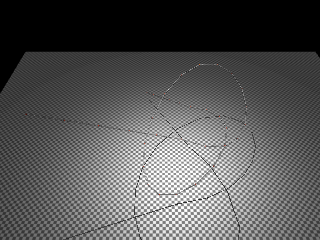

In [332]:
visualize_pos(model, new_positions[-1])

In [310]:
len(new_positions)

280

(245,)



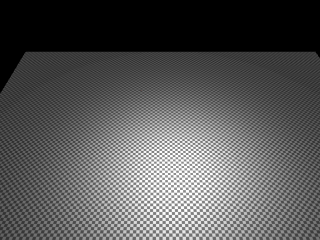

In [298]:
visualize_pos(model, knot_positions[-1])

In [ ]:
pu


In [236]:
knot_positions[-1]

{5: (-1.9643920645687085, 4.7715683848778365, 0.5),
 6: (-1.9643920645687085, 4.7715683848778365, 0.5),
 7: (-1.9643920645687085, 4.7715683848778365, 0.5),
 8: (-1.9643920645687085, 4.7715683848778365, 0.5),
 9: (-1.9643920645687085, 4.7715683848778365, 0.5),
 10: (-1.9643920645687085, 4.7715683848778365, 0.5),
 11: (-1.9643920645687085, 4.7715683848778365, 0.5),
 12: (-1.9643920645687085, 4.7715683848778365, 0.5),
 13: (-1.9643920645687085, 4.7715683848778365, 0.5),
 14: (-1.9643920645687085, 4.7715683848778365, 0.5),
 15: (-1.9643920645687085, 4.7715683848778365, 0.5),
 16: (-1.9643920645687085, 4.7715683848778365, 0.5),
 17: (-1.9643920645687085, 4.7715683848778365, 0.5),
 18: (-1.9643920645687085, 4.7715683848778365, 0.5),
 19: (-1.9643920645687085, 4.7715683848778365, 0.5),
 20: (-1.9643920645687085, 4.7715683848778365, 0.5),
 21: (-1.9643920645687085, 4.7715683848778365, 0.5),
 22: (-1.9643920645687085, 4.7715683848778365, 0.5),
 23: (-1.9643920645687085, 4.7715683848778365, 0.5)


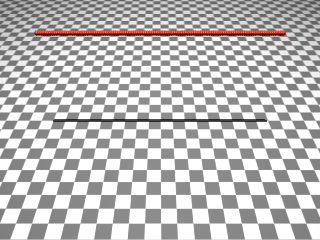

In [165]:
#### GENERATE KNOTTING DYNAMICS #######
num_nodes = 112
G = nx.path_graph(num_nodes)
adjacency = G.adj
pos = nx.spring_layout(G, dim=3)

# make position a linearly spaced path
for i, node in enumerate(pos):
    pos[node] = (i/num_nodes * 2 - 1, 0, 1)


xml = generate_graph_mujoco_xml(adjacency, pos)
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

visualize_pos(model, pos)

In [416]:
def visualize_trajectory(model, position_tensor, save = False, filename = None): 
    '''
    Visualizes a trajectory of positions in MuJoCo

    Inputs:
        model (mujoco.MjModel): MuJoCo model
        position_tensor (np.array): array of shape T x N x D where T is the number of frames, N is the number of nodes, and D is the dimension of the positions
    '''
    data = mujoco.MjData(model)
    # Initial conditions
    num_nodes = len(position_tensor[0])
    positions = np.zeros((num_nodes, 3))  # Store positions (x, y, z)
    for i, pos in enumerate(position_tensor[0]):
        positions[i] = pos

    for i, pos in enumerate(positions):
        data.qpos[7 * i:7 * i + 3] = pos
    # # Simulation parameters
    # duration = 5  # seconds
    framerate = 60  # Hz
    dt = 1.0 / framerate  # Time step size

    pixels = []

    for i in range(len(position_tensor)):
        positions = position_tensor[i]
        # Directly update positions in MuJoCo
        for i, pos in enumerate(positions):
            data.qpos[7 * i:7 * i + 3] = pos
        mujoco.mj_forward(model, data)
        with mujoco.Renderer(model) as renderer:
            renderer.update_scene(data)
            pixels.append(renderer.render())
    media.show_video(pixels, fps = framerate)

    if save:
        media.save_video(pixels, filename, fps = framerate)

    return None


In [417]:
visualize_trajectory(model, new_positions)

AGX: exceeded compiled variants footprint limit


In [420]:
# make a helix graph 
def get_helical_graph(num_nodes, orientation='CCW', radius = 1, height = 1, num_rotations = 1):
    pos = {}
    for i in range(num_nodes):
        theta = 2 * np.pi * i / num_nodes * num_rotations
        if orientation == 'CCW':
            pos[i] = (radius * np.cos(theta), radius * np.sin(theta), height * theta / (2 * np.pi))
        else:
            pos[i] = (radius * np.cos(theta), radius * np.sin(theta), -height * theta / (2 * np.pi))
    G = nx.path_graph(num_nodes)
    adjacency = G.adj
    return pos, adjacency

In [423]:
def extend_graph(pos, num_nodes_head, num_nodes_tail):
    # Linearly extends a given PATH graph by adding nodes to the head (index zero) and tail (last index)
    # estimate gradient of the last num_nodes_tail nodes
    grad = np.zeros(3)
    num_nodes = len(pos)
    tail_grad_estimator = 2
    for i in range(num_nodes - tail_grad_estimator, num_nodes):
        grad += np.array(pos[i]) - np.array(pos[i - 1])
    grad /= num_nodes_tail
    for i in range(num_nodes_tail):
        pos[num_nodes + i] = np.array(pos[num_nodes - 1]) + grad * (i + 1)
    
    head_grad_estimator = 2
    grad = np.zeros(3)
    for i in range(head_grad_estimator):
        grad += np.array(pos[i]) - np.array(pos[i + 1])
    grad /= head_grad_estimator

    for i in range(num_nodes_head):
        pos[-(i + 1)] = np.array(pos[0]) + grad * (i + 1)

    # shift all the node labelings to start at 0
    pos = {k+num_nodes_head:v for k,v in pos.items()}
    # sort pos by node number
    pos = dict(sorted(pos.items()))
    new_num_nodes = len(pos)
    # get the path graph adjacency
    G = nx.path_graph(new_num_nodes)
    adjacency = G.adj
    return pos, adjacency


(490,)



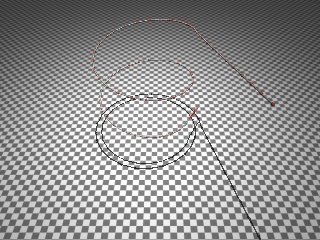

In [428]:
# make a helix graph and visualize it
num_nodes = 50
pos, adjacency = get_helical_graph(num_nodes, orientation = 'CW', radius = 1, height = 1, num_rotations=2)
pos, adjacency = extend_graph(pos, 10, 10)
# ensure that the pos is non-negative in the z direction
min_z = min([pos[node][2] for node in pos])
for node in pos:
    pos[node] = (pos[node][0], pos[node][1], pos[node][2] - min_z + .5)

xml = generate_graph_mujoco_xml(adjacency, pos)
# save the xml
with open('helix.xml', 'w') as f:
    f.write(xml)
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

visualize_pos(model, pos)